0	58.0
1	62.6
2	70.0
3	55.7
4	85.0
5	83.5
6	94.8
7	66.3
8	75.9
9	75.5
10	158.6
11	85.2
12	73.3
13	75.9
14	89.2
15	88.3
16	90.0
17	100.0
18	85.4
19	103.0
20	91.2
21	65.7
22	63.3
23	75.4
24	70.0
25	43.5
26	45.3
27	56.4
28	60.7
29	50.7
30	66.3
31	59.8
32	23.5
33	23.2
34	28.5
35	44.0
36	35.0
37	50.0
38	71.0
39	59.3
40	59.7
41	39.6
42	78.4
43	29.3
44	27.1
45	46.6
46	37.6
47	40.0
48	44.0
49	32.0
50	45.7
51	38.0
52	36.0
53	31.7
54	22.0
55	39.0
56	28.0
57	25.0
58	20.0
59	6.7
60	0.0
61	3.0
62	1.7
63	13.7
64	20.7
65	26.7
66	18.8
67	12.3
68	8.2
69	24.1
70	13.2
71	4.2
72	10.2
73	11.2
74	6.8
75	6.5
76	0.0
77	0.0
78	8.6
79	3.2
80	17.8
81	23.7
82	6.8
83	20.0
84	12.5
85	7.1
86	5.4
87	9.4
88	12.5
89	12.9
90	3.6
91	6.4
92	11.8
93	14.3
94	17.0
95	9.4
96	14.1
97	21.2
98	26.2
99	30.0
100	38.1
101	12.8
102	25.0
103	51.3
104	39.7
105	32.5
106	64.7
107	33.5
108	37.6
109	52.0
110	49.0
111	72.3
112	46.4
113	45.0
114	44.0
115	38.7
116	62.5
117	37.7
118	43.0
119	43.0
120	48.3
121	44.0
122	46.8
123	47.0
124	49.0
1

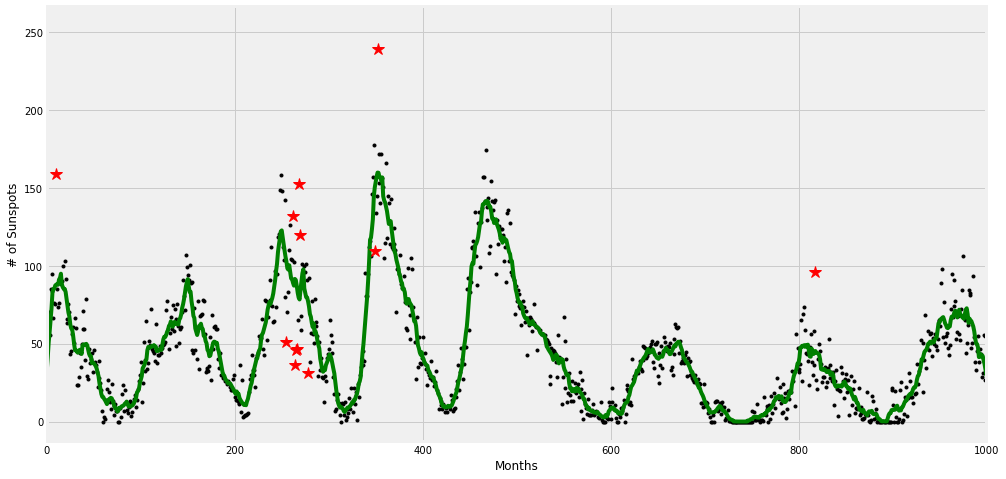

Information about the anomalies model:{'std': 11.424, 'anomalies_dict': OrderedDict([(10, 158.59999999999999), (253, 142.5), (255, 51.0), (262, 132.19999999999999), (264, 36.0), (268, 152.69999999999999), (278, 31.100000000000001), (349, 109.3), (352, 238.90000000000001), (361, 165.69999999999999), (818, 96.200000000000003), (986, 93.400000000000006), (1055, 206.30000000000001), (1069, 84.799999999999997), (1172, 107.09999999999999), (1182, 52.200000000000003), (1185, 180.40000000000001), (1464, 88.299999999999997), (1735, 129.19999999999999), (1882, 107.2), (1890, 103.59999999999999), (1897, 108.2), (2023, 154.5), (2025, 72.200000000000003), (2027, 129.30000000000001), (2171, 108.0), (2274, 165.30000000000001), (2380, 201.30000000000001), (2390, 94.799999999999997), (2391, 189.69999999999999), (2503, 158.0), (2518, 152.30000000000001), (2520, 217.40000000000001), (2521, 143.09999999999999), (2527, 199.59999999999999), (2755, 58.100000000000001), (2756, 138.19999999999999), (2789, 90.9

In [43]:
from __future__ import division
from itertools import count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

!mkdir -p dataset
!curl -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = loadtxt("dataset/sunspots.txt", float)

data_as_frame = pd.DataFrame(data, columns = ['Months', 'Sunspots'])
#print(data_as_frame.head(10))

def moving_average(data, window_size):
    """Computes the moving average using discrete linear convolution."""
    window = np.ones(int(window_size))/(float(window_size))
    return np.convolve(data, window, "same")

def explain_anomalies(y, window_size, sigma = 1.0):
    """Uses stationary standard deviations to explain anomalies."""
    average = moving_average(y, window_size).tolist()
    residual = y - average
    
    #Calculates variance in the distribution of the residual
    std = np.std(residual)
    anomalies = {}
    for index, y_i, avg_i in zip(count(), y, average):
        if (y_i > (avg_i + sigma*std)) | (y_i < (avg_i - sigma*std)):
            anomalies[index] = y_i
            
    anomalies_dict : collections.orderedDict()
    return {'std': round(std,3), 
            'anomalies_dict': collections.OrderedDict(anomalies)}

def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation"""
    average = moving_average(y, window_size).tolist()
    residual = y - average
    
    # Calculate the variation in the distribution of the residual
    testing_std = pd.Series.rolling(residual, window_size).std
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan, testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    
    std = np.std(residual)
    anomalies = {}
    for index, y_i, avg_i, rs_i in zip(count(), y, average, rolling_std):
        if (y_i > (avg_i + sigma*rs_i)) | (y_i < (avg_i - sigma*rs_i)):
            anomalies[index] = y_i
        
    return {'stationary std': round(std, 3),'anomalies_dict': collections.OrderedDict(anomalies)}

def plot_results(x, y, window_size, sigma_value=1,text_xlabel="X Axis", text_ylabel="Y Axis", 
                 applying_rolling_std = False):
    """Generates plot and flags anomalies using moving and stationary standard deviation"""
    
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    plt.grid(True)
    plt.show()

x = data_as_frame['Months']
Y = data_as_frame['Sunspots']

plot_results(x, y=Y, window_size=10, text_xlabel="Months", sigma_value=3,text_ylabel="# of Sunspots")
events = explain_anomalies(y=Y, window_size=5, sigma=3)

print("Information about the anomalies model:{}".format(events))
